# 🏎️ Model v2 3A : XGBoost - Classification

## Step 1 : Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os
from pathlib import Path
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from sklearn.model_selection import (
    RandomizedSearchCV, 
    StratifiedKFold,  
    learning_curve
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    make_scorer
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Step 2 : Load Data

In [2]:
print("Loading processed v2 data...")


train_df = pd.read_parquet('../../../data/processed/train_data_v3.parquet')
test_df = pd.read_parquet('../../../data/processed/test_data_v3.parquet')


train_weights = np.load('../../../data/processed/train_weights_v3.npy')
test_weights = np.load('../../../data/processed/test_weights_v3.npy')


with open('../../../data/processed/metadata_v3.json', 'r') as f:
    metadata = json.load(f)

print(f"\n✅ Data loaded successfully!")
print(f"   Training samples: {len(train_df)} (2024 season)")
print(f"   Test samples: {len(test_df)} (2025 season)")
print(f"   Features: {len(metadata['feature_columns'])}")

Loading processed v2 data...

✅ Data loaded successfully!
   Training samples: 1314 (2024 season)
   Test samples: 385 (2025 season)
   Features: 74


## Step 3 : Prepare features and targets

In [3]:
feature_cols = metadata['feature_columns']

classification_targets = ['win', 'podium', 'points_finish', 'top5']

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train_class = train_df[classification_targets]
y_test_class = test_df[classification_targets]

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]
feature_cols = X_train.columns.tolist()

print(f"\nData prepared!")
print(f"\nClass Imbalance Analysis (Training):")
for target in classification_targets:
    pos_count = train_df[target].sum()
    neg_count = len(train_df) - pos_count
    imbalance_ratio = neg_count / pos_count if pos_count > 0 else 0
    print(f"   {target:15s}: {pos_count:4d} positive ({pos_count/len(train_df)*100:5.1f}%) | "
          f"{neg_count:4d} negative | Ratio: 1:{imbalance_ratio:.1f}")


Data prepared!

Class Imbalance Analysis (Training):
   win            :   68 positive (  5.2%) | 1246 negative | Ratio: 1:18.3
   podium         :  204 positive ( 15.5%) | 1110 negative | Ratio: 1:5.4
   points_finish  :  662 positive ( 50.4%) |  652 negative | Ratio: 1:1.0
   top5           :  340 positive ( 25.9%) |  974 negative | Ratio: 1:2.9


## Step 4 : Define Evaluate functions

In [4]:
def calculate_classification_metrics(y_true, y_pred, y_prob=None, weights=None):
   
    acc = accuracy_score(y_true, y_pred, sample_weight=weights)
    prec = precision_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    rec = recall_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    f1 = f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    auc = roc_auc_score(y_true, y_prob, sample_weight=weights) if y_prob is not None else None
    
    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': auc
    }


def find_optimal_threshold(y_true, y_prob, weights=None):
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    
    return best_threshold, best_f1


def plot_learning_curve(model, X, y, weights=None, cv=5, title="Learning Curve"):

    fit_params = {'sample_weight': weights} if weights is not None else None
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        n_jobs=-1,
        scoring='f1' if hasattr(y, 'unique') and len(np.unique(y)) == 2 else 'neg_mean_absolute_error',
        fit_params= fit_params
    )   
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='#3671C6', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3671C6')
    plt.plot(train_sizes, val_mean, label='CV score', color='#E10600', marker='s')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#E10600')
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Evaluation functions defined!")

Evaluation functions defined!


## Step 5 : Baseline Classification Model

In [5]:
baseline_class_models = {}
baseline_class_results = {}

for target in classification_targets:
    print(f"\n  Training baseline XGBoost classifier for '{target}'...")
    

    pos_count = y_train_class[target].sum()
    neg_count = len(y_train_class[target]) - pos_count
    scale_pos_weight = neg_count / pos_count
    print(f"   Target: '{target}', Imbalance Ratio: 1:{scale_pos_weight:.1f}. Using 'scale_pos_weight'.")
    
    
    baseline_class_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',  
        'n_estimators': 1000,      
        'max_depth': 6,            
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'scale_pos_weight': scale_pos_weight, 
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBClassifier(**baseline_class_params)
    
    
    model.fit(
        X_train, y_train_class[target],
        sample_weight=train_weights,
        eval_set=[(X_test, y_test_class[target])],
        sample_weight_eval_set=[test_weights], 
        early_stopping_rounds=50,
        verbose=False
    )
    
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_prob = model.predict_proba(X_train)[:, 1]
    test_prob = model.predict_proba(X_test)[:, 1]
    
    
    optimal_thresh, optimal_f1 = find_optimal_threshold(
        y_test_class[target], test_prob, test_weights
    )
    test_pred_optimized = (test_prob >= optimal_thresh).astype(int)
    
    
    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights
    )
    test_metrics_optimized = calculate_classification_metrics(
        y_test_class[target], test_pred_optimized, test_prob, test_weights
    )
    
    
    baseline_class_models[target] = model
    baseline_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'test_metrics_optimized': test_metrics_optimized,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'test_pred_optimized': test_pred_optimized,
        'train_prob': train_prob,
        'test_prob': test_prob,
        'optimal_threshold': optimal_thresh,
        'best_iteration': model.best_iteration
    }
    
    print(f"   ✅ {target}:")
    print(f"      Best iteration found: {model.best_iteration}")
    print(f"      Default (0.5):  F1 = {test_metrics['F1']:.3f}, AUC = {test_metrics['AUC']:.3f}")
    print(f"      Optimized ({optimal_thresh:.2f}): F1 = {test_metrics_optimized['F1']:.3f} ⭐")

print("\n✅ All baseline classification models trained!")


  Training baseline XGBoost classifier for 'win'...
   Target: 'win', Imbalance Ratio: 1:18.3. Using 'scale_pos_weight'.
   ✅ win:
      Best iteration found: 379
      Default (0.5):  F1 = 0.616, AUC = 0.963
      Optimized (0.50): F1 = 0.616 ⭐

  Training baseline XGBoost classifier for 'podium'...
   Target: 'podium', Imbalance Ratio: 1:5.4. Using 'scale_pos_weight'.
   ✅ podium:
      Best iteration found: 116
      Default (0.5):  F1 = 0.754, AUC = 0.958
      Optimized (0.45): F1 = 0.769 ⭐

  Training baseline XGBoost classifier for 'points_finish'...
   Target: 'points_finish', Imbalance Ratio: 1:1.0. Using 'scale_pos_weight'.
   ✅ points_finish:
      Best iteration found: 47
      Default (0.5):  F1 = 0.794, AUC = 0.844
      Optimized (0.45): F1 = 0.795 ⭐

  Training baseline XGBoost classifier for 'top5'...
   Target: 'top5', Imbalance Ratio: 1:2.9. Using 'scale_pos_weight'.
   ✅ top5:
      Best iteration found: 79
      Default (0.5):  F1 = 0.785, AUC = 0.913
      Optimi

## Step 6 : Analyse Learning Curves


📊 Analyzing 'win'...


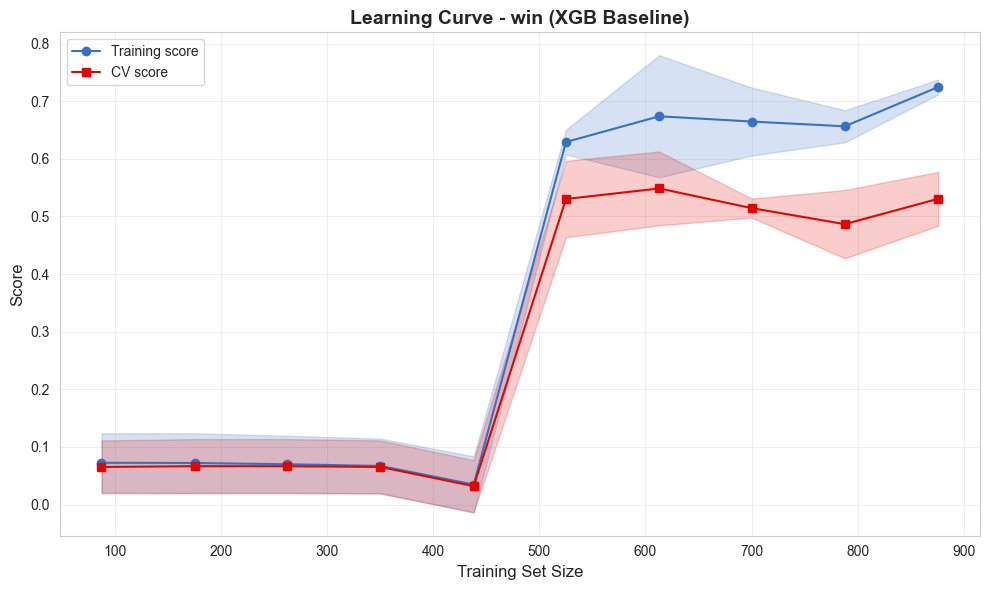


📊 Analyzing 'podium'...


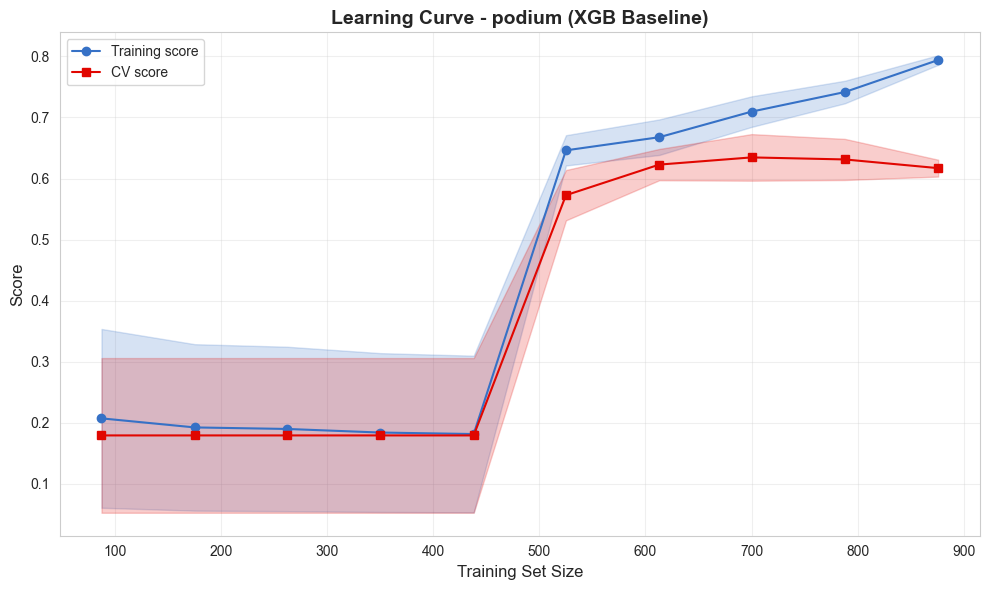


📊 Analyzing 'points_finish'...


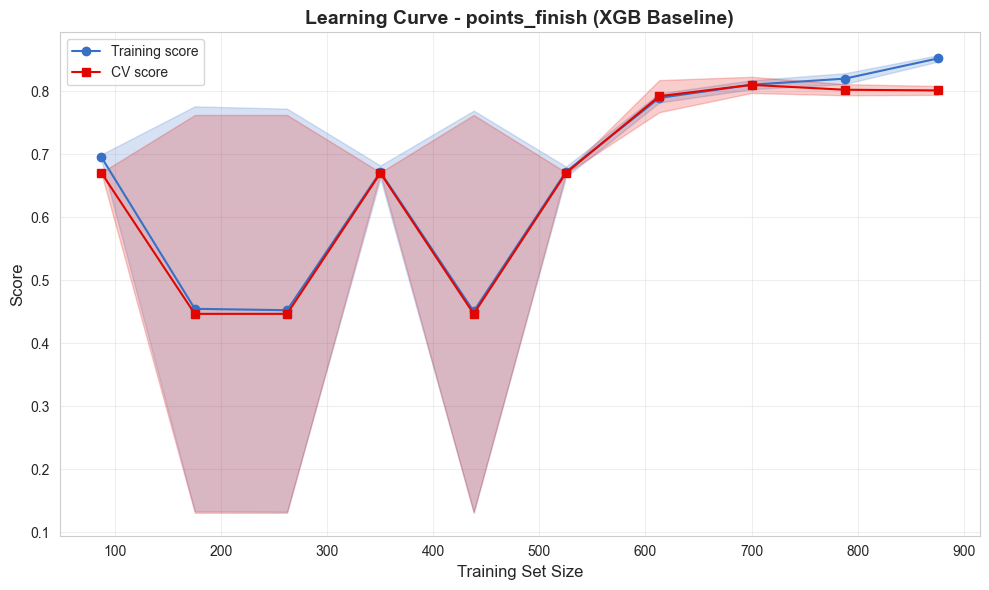


📊 Analyzing 'top5'...


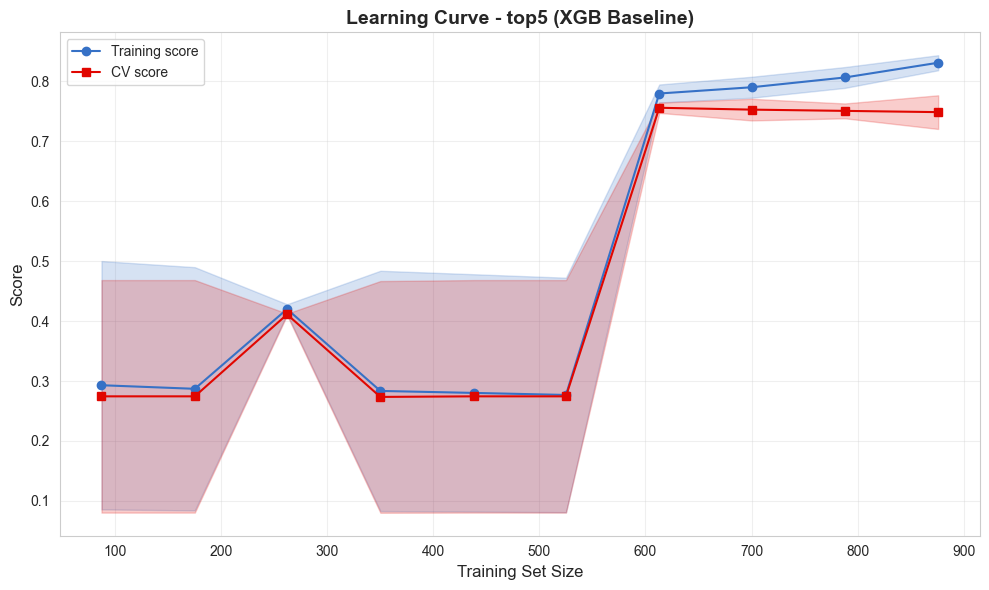

✅ Learning curve analysis complete!


In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for target in classification_targets:
    print(f"\n📊 Analyzing '{target}'...")
    
    
    pos_count = y_train_class[target].sum()
    neg_count = len(y_train_class[target]) - pos_count
    scale_pos_weight = neg_count / pos_count
    
   
    temp_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=1000, 
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )
    
    plot_learning_curve(
        temp_model,
        X_train,
        y_train_class[target],
        weights=train_weights,
        cv=skf,
        title=f"Learning Curve - {target} (XGB Baseline)"
    )

print("✅ Learning curve analysis complete!")

## Step 7 : Optimized Hyperparameter Search

In [7]:
class_param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'gamma': [0, 0.1, 0.5] 
}

print("\n Optimization Search Space:")
print(f"   Testing 30 random combinations per target")
print(f"   Using StratifiedKFold CV (3 folds)")
print(f"   Expected time: 5-15 minutes per target\n")

optimized_class_models = {}
optimized_class_results = {}
cv_results_class = {}

for target in classification_targets:
    print(f"\n Optimizing '{target}' with XGBoost...")
    
    
    pos_count = y_train_class[target].sum()
    neg_count = len(y_train_class[target]) - pos_count
    scale_pos_weight = neg_count / pos_count
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, zero_division=0)
    
    random_search = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42, 
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight 
        ),
        param_distributions=class_param_grid,
        n_iter=30,
        scoring=f1_scorer,
        cv=skf,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    
    random_search.fit(X_train, y_train_class[target], sample_weight=train_weights)
    
   
    best_params = random_search.best_params_
    
    
    best_model_optimized = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42, 
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        **best_params
    )
    
    best_model_optimized.fit(
        X_train, y_train_class[target],
        sample_weight=train_weights,
        eval_set=[(X_test, y_test_class[target])],
        sample_weight_eval_set=[test_weights],
        early_stopping_rounds=50,
        verbose=False
    )
    
  
    train_pred = best_model_optimized.predict(X_train)
    test_pred = best_model_optimized.predict(X_test)
    train_prob = best_model_optimized.predict_proba(X_train)[:, 1]
    test_prob = best_model_optimized.predict_proba(X_test)[:, 1]
    
    
    optimal_thresh, optimal_f1 = find_optimal_threshold(
        y_test_class[target], test_prob, test_weights
    )
    test_pred_optimized = (test_prob >= optimal_thresh).astype(int)
    
    
    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights
    )
    test_metrics_optimized = calculate_classification_metrics(
        y_test_class[target], test_pred_optimized, test_prob, test_weights
    )
    
    
    optimized_class_models[target] = best_model_optimized
    optimized_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'test_metrics_optimized': test_metrics_optimized,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'test_pred_optimized': test_pred_optimized,
        'train_prob': train_prob,
        'test_prob': test_prob,
        'best_params': best_params,
        'optimal_threshold': optimal_thresh,
        'best_iteration': best_model_optimized.best_iteration
    }
    cv_results_class[target] = pd.DataFrame(random_search.cv_results_)
    
    print(f"    CV F1: {random_search.best_score_:.3f}")
    print(f"    Test F1 (optimized): {test_metrics_optimized['F1']:.3f}")

print("\nAll classification models optimized!")


 Optimization Search Space:
   Testing 30 random combinations per target
   Using StratifiedKFold CV (3 folds)
   Expected time: 5-15 minutes per target


 Optimizing 'win' with XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    CV F1: 0.428
    Test F1 (optimized): 0.587

 Optimizing 'podium' with XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    CV F1: 0.644
    Test F1 (optimized): 0.765

 Optimizing 'points_finish' with XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    CV F1: 0.840
    Test F1 (optimized): 0.806

 Optimizing 'top5' with XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    CV F1: 0.791
    Test F1 (optimized): 0.789

All classification models optimized!


## Step 8 : Comparision

In [8]:
print("\n" + "="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON (XGBoost)")
print("="*80)

comparison_data = []

for target in classification_targets:
    baseline = baseline_class_results[target]['test_metrics_optimized']
    optimized = optimized_class_results[target]['test_metrics_optimized']
    
    row = {
        'Target': target,
        'Baseline_F1': baseline['F1'],
        'Optimized_F1': optimized['F1'],
        'Baseline_AUC': baseline['AUC'],
        'Optimized_AUC': optimized['AUC'],
        'Improvement_F1_pct': ((optimized['F1'] - baseline['F1']) / baseline['F1'] * 100) if baseline['F1'] > 0 else 0
    }
    comparison_data.append(row)

comparison_class_df = pd.DataFrame(comparison_data)

print("\n📊 Detailed Comparison:")
display(comparison_class_df)

print("\n💡 ANALYSIS:")
for _, row in comparison_class_df.iterrows():
    target = row['Target']
    baseline_opt_f1 = row['Baseline_F1']
    optimized_f1 = row['Optimized_F1']
    
    if optimized_f1 > baseline_opt_f1:
        print(f"   ✅ {target}: Optimized BETTER by {row['Improvement_F1_pct']:.1f}% "
              f"(F1: {baseline_opt_f1:.3f} → {optimized_f1:.3f})")
    elif abs(optimized_f1 - baseline_opt_f1) < 0.01:
        print(f"   ≈  {target}: Similar performance (F1: {baseline_opt_f1:.3f} vs {optimized_f1:.3f})")
    else:
        print(f"   ⚠️  {target}: Baseline BETTER (F1: {baseline_opt_f1:.3f} vs {optimized_f1:.3f})")


📊 COMPREHENSIVE MODEL COMPARISON (XGBoost)

📊 Detailed Comparison:


,Target,Baseline_F1,Optimized_F1,Baseline_AUC,Optimized_AUC,Improvement_F1_pct
0,win,0.616410,0.586904,0.963198,0.962053,-4.786623
1,podium,0.768769,0.764810,0.957928,0.957256,-0.515040
2,points_finish,0.794560,0.805879,0.844166,0.846697,1.424461
3,top5,0.785242,0.789070,0.913418,0.910996,0.487564



💡 ANALYSIS:
   ⚠️  win: Baseline BETTER (F1: 0.616 vs 0.587)
   ≈  podium: Similar performance (F1: 0.769 vs 0.765)
   ✅ points_finish: Optimized BETTER by 1.4% (F1: 0.795 → 0.806)
   ✅ top5: Optimized BETTER by 0.5% (F1: 0.785 → 0.789)


## Step 9 : Visaualisation

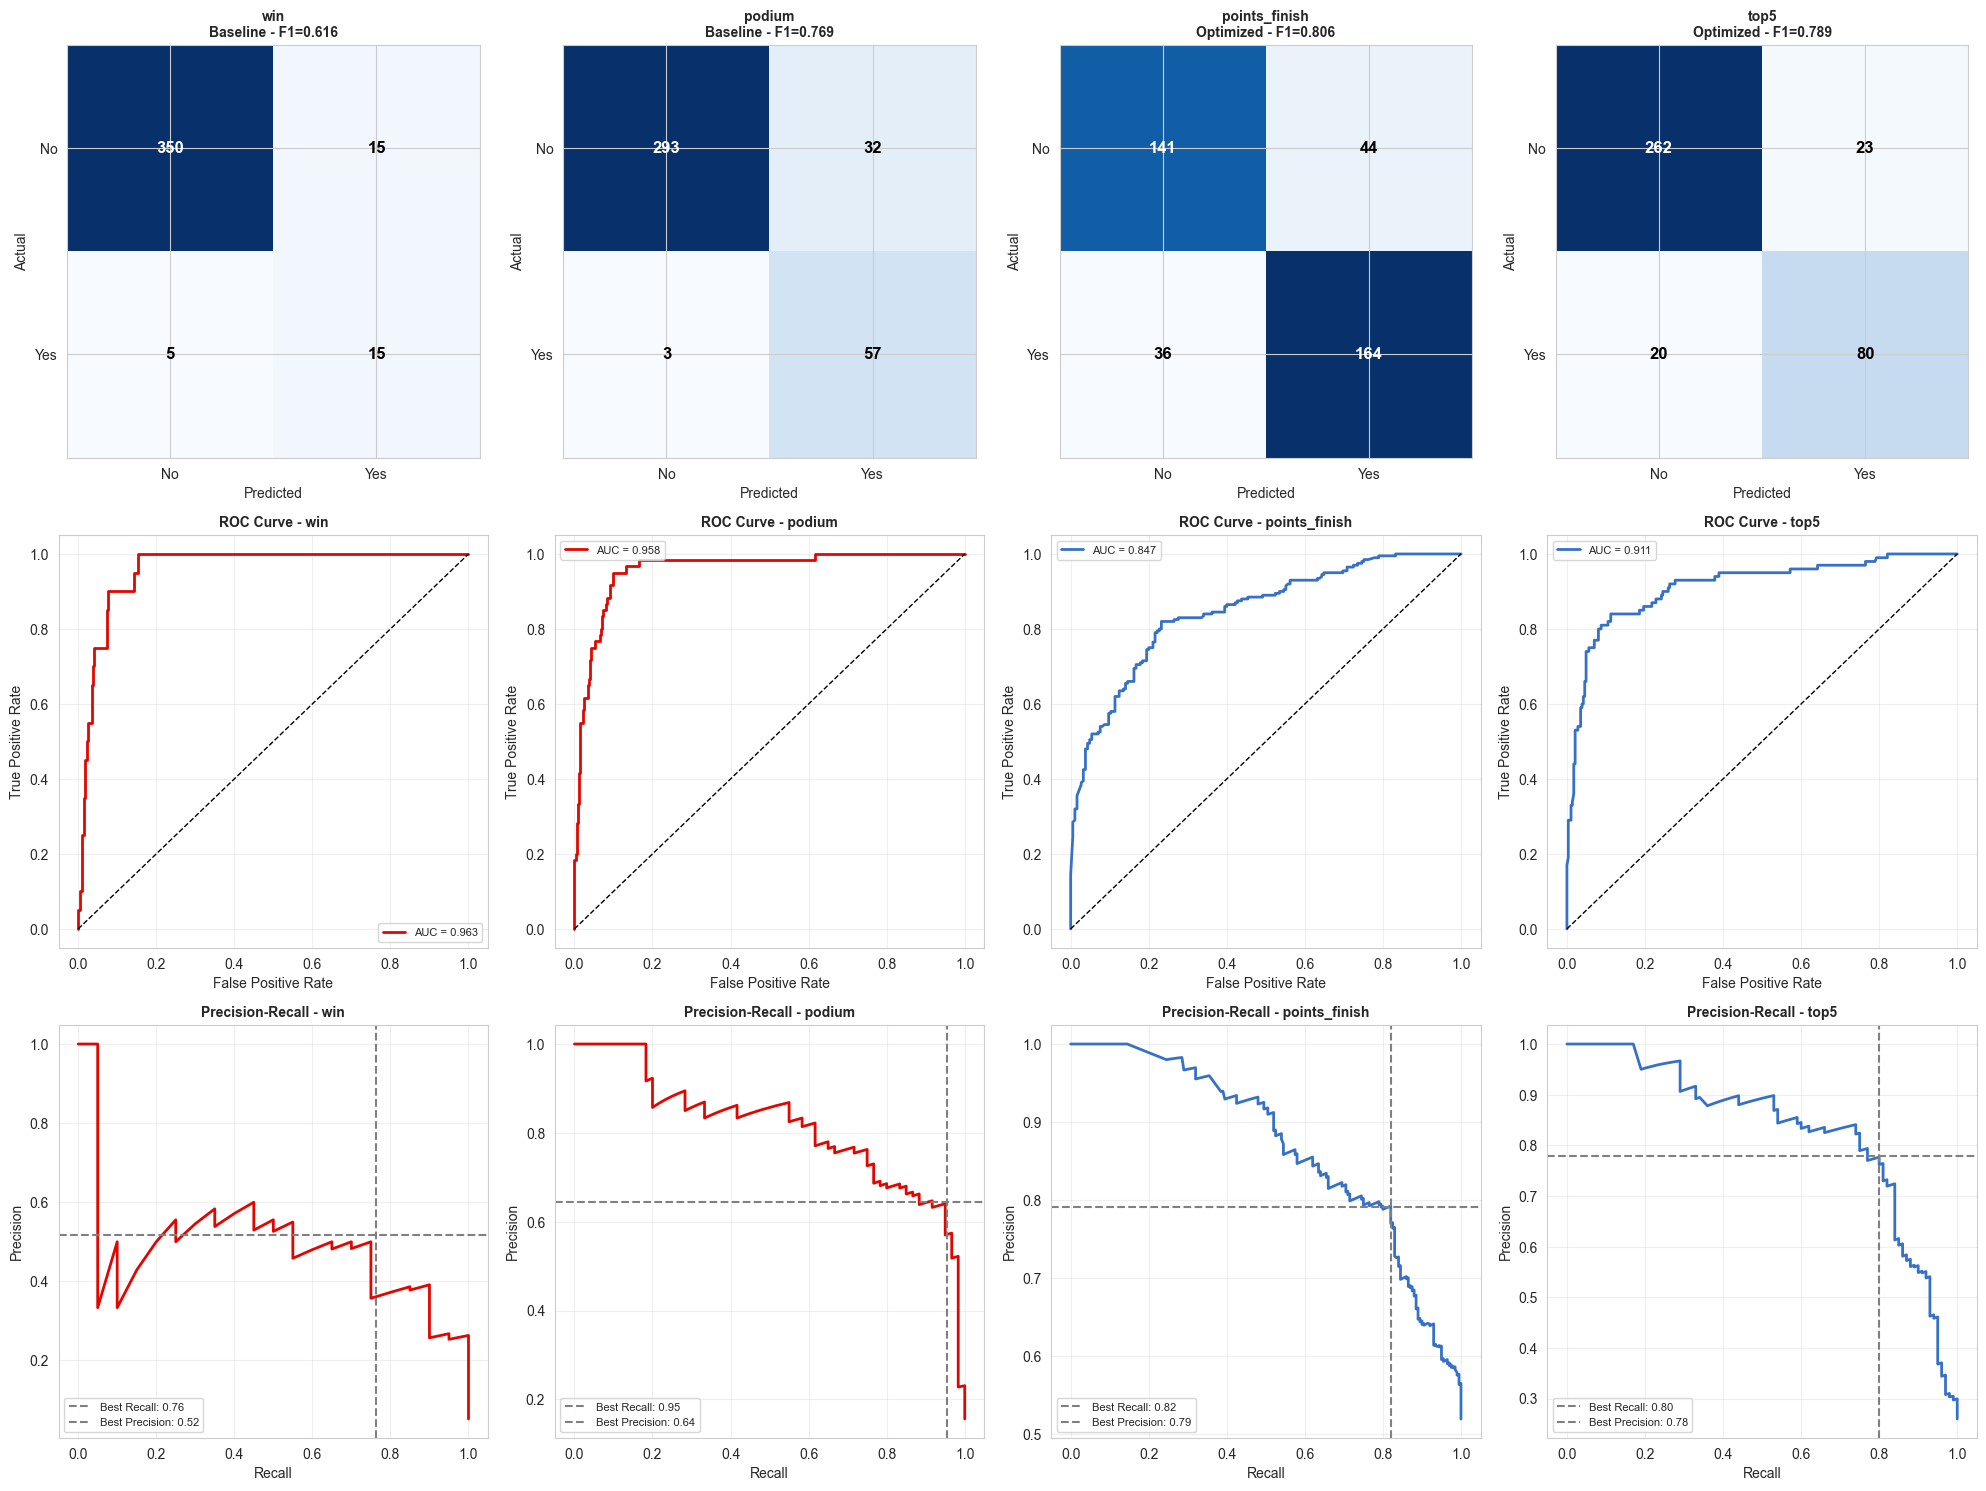

✅ Detailed visualizations complete!


In [9]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for idx, target in enumerate(classification_targets):
    # Determine which model is better
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 >= baseline_f1:
        best_results = optimized_class_results[target]
        model_label = "Optimized"
        color = '#3671C6'
    else:
        best_results = baseline_class_results[target]
        model_label = "Baseline"
        color = '#E10600'
    
    # Row 1: Confusion Matrix
    cm = confusion_matrix(y_test_class[target], best_results['test_pred_optimized'])
    axes[0, idx].imshow(cm, cmap='Blues')
    axes[0, idx].set_title(f'{target}\n{model_label} - F1={best_results["test_metrics_optimized"]["F1"]:.3f}', 
                           fontweight='bold', fontsize=10)
    axes[0, idx].set_xlabel('Predicted')
    axes[0, idx].set_ylabel('Actual')
    axes[0, idx].set_xticks([0, 1])
    axes[0, idx].set_yticks([0, 1])
    axes[0, idx].set_xticklabels(['No', 'Yes'])
    axes[0, idx].set_yticklabels(['No', 'Yes'])
    
    for i in range(2):
        for j in range(2):
            axes[0, idx].text(j, i, str(cm[i, j]), ha='center', va='center',
                              color='white' if cm[i, j] > cm.max()/2 else 'black',
                              fontsize=12, fontweight='bold')
    
    # Row 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_test_class[target], best_results['test_prob'])
    axes[1, idx].plot(fpr, tpr, color=color, lw=2, 
                      label=f'AUC = {best_results["test_metrics_optimized"]["AUC"]:.3f}')
    axes[1, idx].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[1, idx].set_xlabel('False Positive Rate')
    axes[1, idx].set_ylabel('True Positive Rate')
    axes[1, idx].set_title(f'ROC Curve - {target}', fontweight='bold', fontsize=10)
    axes[1, idx].legend(fontsize=8)
    axes[1, idx].grid(alpha=0.3)
    
    # Row 3: Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(
        y_test_class[target], best_results['test_prob']
    )
    axes[2, idx].plot(recall, precision, color=color, lw=2)
    axes[2, idx].axvline(best_results['test_metrics_optimized']['Recall'], color='gray', 
                         linestyle='--', label=f'Best Recall: {best_results["test_metrics_optimized"]["Recall"]:.2f}')
    axes[2, idx].axhline(best_results['test_metrics_optimized']['Precision'], color='gray', 
                         linestyle='--', label=f'Best Precision: {best_results["test_metrics_optimized"]["Precision"]:.2f}')
    axes[2, idx].set_xlabel('Recall')
    axes[2, idx].set_ylabel('Precision')
    axes[2, idx].set_title(f'Precision-Recall - {target}', fontweight='bold', fontsize=10)
    axes[2, idx].legend(fontsize=8)
    axes[2, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Detailed visualizations complete!")

## Step 10 : Feature importance


🏆 FEATURE IMPORTANCE ANALYSIS (XGBoost)

📊 Analyzing best performer: 'points_finish'

🏆 TOP 15 FEATURES (points_finish - Optimized model):

driver_id                           ████████████████████████████████████████ 0.2653
quali_position                      ████████████████████████ 0.1649
q3_gap_to_pole                      ████████████████ 0.1077
weighted_points_5                   ████████████ 0.0844
avg_quali_position_5                ██████ 0.0432
driver_circuit_weighted_points      █████ 0.0351
grid_position                       █████ 0.0340
team_weighted_points_5              ████ 0.0292
team_weighted_avg_position_5        ████ 0.0274
championship_position_before_race   ████ 0.0274
weighted_podium_rate_5              ████ 0.0270
driver_circuit_weighted_pos         ████ 0.0267
weighted_avg_position_5             ███ 0.0227
team_id                             ██ 0.0195
points_to_leader                    ██ 0.0195


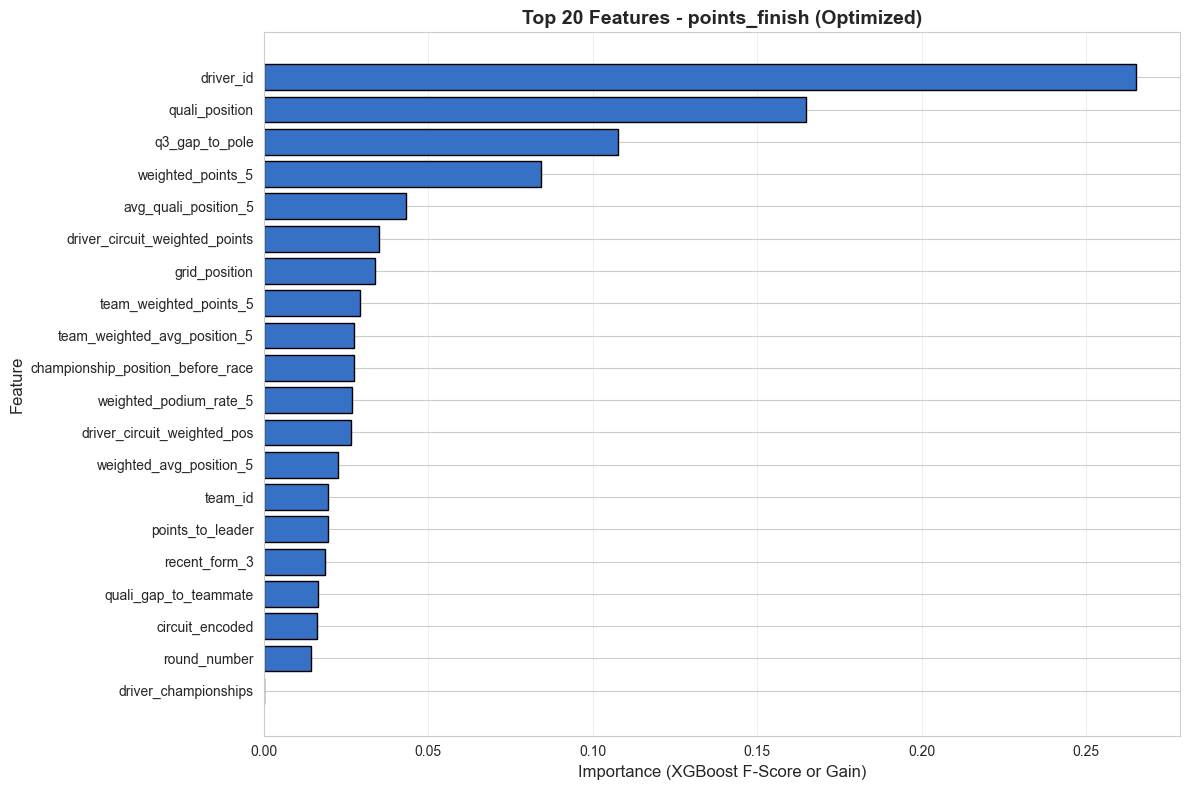

In [10]:
print("\n" + "="*80)
print("🏆 FEATURE IMPORTANCE ANALYSIS (XGBoost)")
print("="*80)

# Analyze feature importance for best performing target
best_target = comparison_class_df.loc[comparison_class_df['Optimized_F1'].idxmax(), 'Target']
print(f"\n📊 Analyzing best performer: '{best_target}'")

if optimized_class_results[best_target]['test_metrics_optimized']['F1'] >= \
   baseline_class_results[best_target]['test_metrics_optimized']['F1']:
    best_model = optimized_class_models[best_target]
    model_type = "Optimized"
else:
    best_model = baseline_class_models[best_target]
    model_type = "Baseline"

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 15 FEATURES ({best_target} - {model_type} model):\n")
for idx, row in feature_importance.head(15).iterrows():
    bar = '█' * int(row['importance'] / feature_importance['importance'].max() * 40)
    print(f"{row['feature'][:35]:35s} {bar} {row['importance']:.4f}") # Use .4f for float

# Visualize
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='#3671C6', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (XGBoost F-Score or Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top 20 Features - {best_target} ({model_type})', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 11 : Save Models

In [11]:
os.makedirs('../models', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

saved_files = []

print("\n" + "="*80)
print("💾 SAVING BEST XGBOOST CLASSIFICATION MODELS (v2)")
print("="*80)

for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 >= baseline_f1:
        model_to_save = optimized_class_models[target]
        results = optimized_class_results[target]
        model_type = "Optimized"
    else:
        model_to_save = baseline_class_models[target]
        results = baseline_class_results[target]
        model_type = "Baseline"
    
    # Save model
    model_path = f'../models/XGB_Classifier_{target}_{model_type}_v2_{timestamp}.pkl'
    joblib.dump(model_to_save, model_path)
    saved_files.append(model_path)
    
    print(f"\n✅ {target:15s}: {model_type:10s} | F1={results['test_metrics_optimized']['F1']:.3f} | "
          f"Threshold={results['optimal_threshold']:.2f}")

# Save metadata
metadata_dict = {
    'timestamp': datetime.now().isoformat(),
    'version': 'v2_xgboost',
    'model_family': 'XGBoost',
    'features': feature_cols,
    'classification_targets': classification_targets,
    'models': {}
}

for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 >= baseline_f1:
        results = optimized_class_results[target]
        model_type = "Optimized"
    else:
        results = baseline_class_results[target]
        model_type = "Baseline"
    
    metadata_dict['models'][target] = {
        'model_type': model_type,
        'test_f1': float(results['test_metrics_optimized']['F1']),
        'test_auc': float(results['test_metrics_optimized']['AUC']),
        'optimal_threshold': float(results['optimal_threshold']),
        'best_iteration': int(results['best_iteration'])
    }

metadata_path = f'../models/XGB_Classification_Metadata_v2_{timestamp}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_dict, f, indent=2)
saved_files.append(metadata_path)

# Save comparison
comparison_path = f'../models/XGB_Classification_Comparison_v2_{timestamp}.csv'
comparison_class_df.to_csv(comparison_path, index=False)
saved_files.append(comparison_path)

print(f"\n💾 Metadata: {metadata_path}")
print(f"📊 Comparison: {comparison_path}")
print(f"\n✅ All classification files saved! Total: {len(saved_files)} files")


💾 SAVING BEST XGBOOST CLASSIFICATION MODELS (v2)

✅ win            : Baseline   | F1=0.616 | Threshold=0.50

✅ podium         : Baseline   | F1=0.769 | Threshold=0.45

✅ points_finish  : Optimized  | F1=0.806 | Threshold=0.45

✅ top5           : Optimized  | F1=0.789 | Threshold=0.60

💾 Metadata: ../models/XGB_Classification_Metadata_v2_20251102_231730.json
📊 Comparison: ../models/XGB_Classification_Comparison_v2_20251102_231730.csv

✅ All classification files saved! Total: 6 files


# Classification Summary

In [13]:
print("\n" + "="*80)
print("🏁 XGBOOST CLASSIFICATION (v3) - FINAL SUMMARY")
print("="*80)

print("\n📊 BEST MODELS PERFORMANCE (with optimized thresholds):\n")
for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    best_f1 = max(baseline_f1, optimized_f1)
    model_type = "Optimized" if optimized_f1 >= baseline_f1 else "Baseline"
    results = optimized_class_results[target] if optimized_f1 >= baseline_f1 else baseline_class_results[target]
    
    print(f"   {target:15s} | {model_type:10s} | F1: {best_f1:.3f} | "
          f"AUC: {results['test_metrics_optimized']['AUC']:.3f} | "
          f"Acc: {results['test_metrics_optimized']['Accuracy']:.3f}")




🏁 XGBOOST CLASSIFICATION (v3) - FINAL SUMMARY

📊 BEST MODELS PERFORMANCE (with optimized thresholds):

   win             | Baseline   | F1: 0.616 | AUC: 0.963 | Acc: 0.951
   podium          | Baseline   | F1: 0.769 | AUC: 0.958 | Acc: 0.910
   points_finish   | Optimized  | F1: 0.806 | AUC: 0.847 | Acc: 0.794
   top5            | Optimized  | F1: 0.789 | AUC: 0.911 | Acc: 0.888
